In [3]:
FACES_DIR = "./train_images/"

In [1]:
#from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dropout
#from keras.models import Model
#from keras.objectives import binary_crossentropy
#from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, EarlyStopping
#from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from scipy.stats import norm
import os
#import keras
import numpy as np
import matplotlib.pyplot as plt
#import keras.backend as K
#import tensorflow as tf

import datetime

In [8]:
m = 50
n_z = 2 # latent dimension
n_epoch = 10
img_shape = (28,28,1)

# Q(z|X) -- encoder
inputs = Input(shape=img_shape)
"""
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)
"""
x = Conv2D(32,3, padding="same", activation="relu")(inputs)
x = Conv2D(64,3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64,3, padding="same", activation="relu")(x)
x = Conv2D(64,3, padding="same", activation="relu")(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation="relu")(x)
mu = Dense(n_z, activation="linear")(x) # mean of the distribution
log_sigma = Dense(n_z, activation="linear")(x) 



In [5]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(K.shape(mu)[0], 2), mean=0., stddev=1.)
    return mu + K.exp(log_sigma) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])


In [10]:
# P(X|z) -- decoder

"""
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)
"""
d_in = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation="relu") (d_in)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(1,3, padding="same", activation="sigmoid")(x)
decoder = Model(d_in, x)

In [11]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [176]:
z_decoded = decoder(z)

In [175]:
y = CustomVariationalLayer()([inputs, z_decoded])

()


In [174]:
# Overall VAE model, for reconstruction and training
#vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
#encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
#d_in = Input(shape=(n_z,))
#d_h = decoder_hidden(d_in)
#d_out = decoder_out(d_h)
#decoder = Model(d_in, d_out)
vae = Model(inputs, y)
vae.compile(optimizer="rmsprop", loss=None)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [2]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        kl_loss = -5e-4*K.mean(
            1+log_sigma-K.square(mu) - K.exp(log_sigma), axis=-1
        )
        return K.mean(xent_loss+kl_loss, axis=-1)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x,z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # we discard this but the layer must return something


## ImageDataGenerator

In [179]:
batch_size = 32

datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)
image_data_generator = datagen.flow_from_directory("/home/sam/Desktop/temp/",
        target_size=img_shape[0:2],
        class_mode=None, color_mode="grayscale")
test_data_generator = datagen.flow_from_directory("/home/sam/Desktop/test/",
        target_size=img_shape[0:2], 
        class_mode=None, color_mode="grayscale")

Found 5018 images belonging to 1 classes.
Found 1090 images belonging to 1 classes.


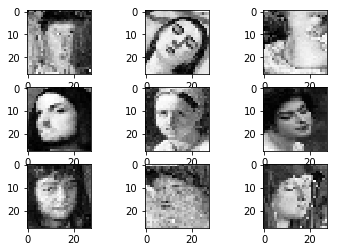

In [22]:
for i in range(9):
    p = image_data_generator.next()[0]
    
    plt.subplot(330+i+1)
    plt.imshow(p.reshape(28,28), cmap="Greys_r")
plt.show()

Random 9 faces from the training set

## Data Exploration Functions

In [210]:
height_arr = []
width_arr = []
for file in os.listdir(FACES_DIR):
    try:
        width, height = Image.open(FACES_DIR+file).size
        height_arr.append(height)
        width_arr.append(height)
    except:
        pass

In [105]:
def removeNonImages(dr=FACES_DIR):
    """
    Warning this deletes all non-image files 
    """
    count = 0 
     
    for file in os.listdir(dr):
        try:
            p = Image.open(dr+file)
            
        except:
            os.remove(dr + file)
            count += 1
    return count

In [106]:
removeNonImages("/home/sam/Desktop/temp/faces/")

6

In [5]:
img_shape=(64,64)

In [6]:
def removeSmallImages(dr=FACES_DIR, size=img_shape[0:2], sigma=0.1, tmp_dir=None, delete_non_existing=False):
    """
    (String, tuple of Ints, float, String, Boolean) -> None
    Removes all images found in folder that are smaller than the specified size tuple by sigma*100%
    If tmp_dir is specified, then the smaller images are moved to that specified directory
    if not then they are deleted.
    If delete_non_existing is specified then all files that cannot be seen as images in that directory
    are deleted.
    """
    if (tmp_dir != None and not os.path.exists(tmp_dir)) or not os.path.exists(dr):
        raise ValueError("Temporary directory does not exist")
    t = []
   
    for filel in os.listdir(dr):
        try:
            
            p = Image.open(dr+filel)
            w, h = p.size
            
            if size[1] <= w and size[0] <= h:
                
                pass
            elif h/float(size[0]) < (1.0-sigma) or w/float(size[1]) < (1.0-sigma):
                
                if tmp_dir == None:
                    os.remove(dr + filel) # if no temp folder is specified just delete the image
                else:
                    t.append((dr+filel, tmp_dir+filel))
                    os.rename(dr+filel, tmp_dir + filel) # if one is specified then just move the smaller images
        except:
            if delete_non_existing:
                os.remove(dr+filel)
    return t

In [8]:
import os

In [11]:
p = removeSmallImages("./image_too_small/test/", tmp_dir="./image_too_small/test_small/")

In [12]:
for t, q in p:
    os.rename(t, q)

In [3]:
def fixed_generator(gen):
    for batch in gen:
        yield (batch, None)

## Experimentation

### Baseline

In [6]:
callbacks = [

    ModelCheckpoint(
        filepath="/home/sam/Desktop/Classical/models/weights.{epoch:02d}.hdf5"
    )
    
]

In [ ]:
history = vae.fit_generator(fixed_generator(image_data_generator),
        samples_per_epoch=157,
        epochs=20,
        callbacks=callbacks)

In [16]:
baseline = keras.models.load_model("models/weights.09.hdf5", 
                        custom_objects={"CustomVariationalLayer":CustomVariationalLayer()}, compile=False)

()


In [17]:
baseline.compile(loss=None, optimizer="rmsprop")

In [35]:
def displayImages(decoder,batch_size, n=15, dim=(28,28), directory=None, name=None):
    savefig = directory != None
    if savefig and not name:
        print("Warning: You specified a directory to save the file, but you did not specify the name of the file")
        name = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
        print("The file will be saved as a timestamp, ie,", name)
    if savefig and not os.path.isdir(directory):
        raise ValueError("\"" + directory + "\" is not a directory")
    figure = np.zeros((dim[1] * n, dim[0]*n))
    grid_x = norm.ppf(np.linspace(0.05,0.95,n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    
    
    for index, yindex in enumerate(grid_x):
        for j, xindex in enumerate(grid_y):
            z_sample = np.array([[xindex, yindex, 0, 0,0,0,0,0,0,0]]) # sample a random point
            z_sample = np.tile(z_sample, batch_size).reshape(batch_size,10)
            
            x_decoded = decoder.predict(z_sample, batch_size=batch_size) # 
            digit = x_decoded[0].reshape(dim)
            
            figure[index*dim[1]: (index+1) * dim[1],
                   j*dim[0]: (j+1) * dim[0]] = digit
    
    
    
    
    plt.figure(figsize=(10,10))
    plt.imshow(figure, cmap="Greys_r")
    if savefig:
        plt.savefig(os.path.join(directory, name + ".png"))
    plt.show()

In [52]:
decoder = baseline.get_layer(name="model_1")

The file will be saved as a timestamp, ie, 2019-03-23 15:08:11.720790


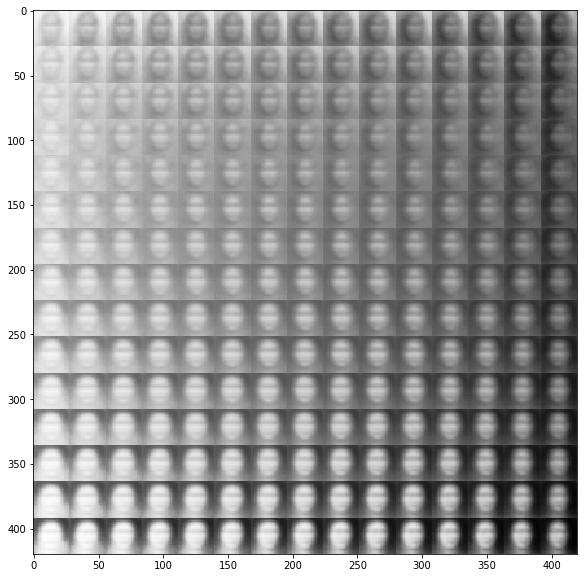

In [102]:
displayImages(decoder, directory="/home/sam/Desktop/Classical/figs/")

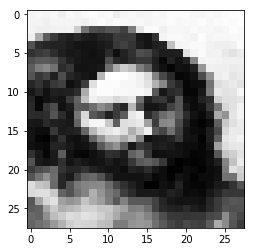

In [67]:
test = image_data_generator.next()[0]
plt.imshow(test.reshape(28,28), cmap="Greys_r")

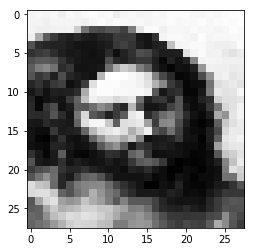

In [68]:
q = baseline.predict(x=test.reshape(1,28,28,1))
plt.imshow(q.reshape(28,28), cmap="Greys_r")

In [14]:
def getParams(model, image, output_layer="lambda_1", batch=False):
    p = Model(model.input, model.get_layer(name=output_layer).output)
    if not batch:
        size = (1,*image.shape)
    else:
        size = image.shape
    temp = p.predict(image.reshape(size))
    return temp

In [159]:
getParams(baseline, test)

array([[1.09972  , 0.3975713]], dtype=float32)

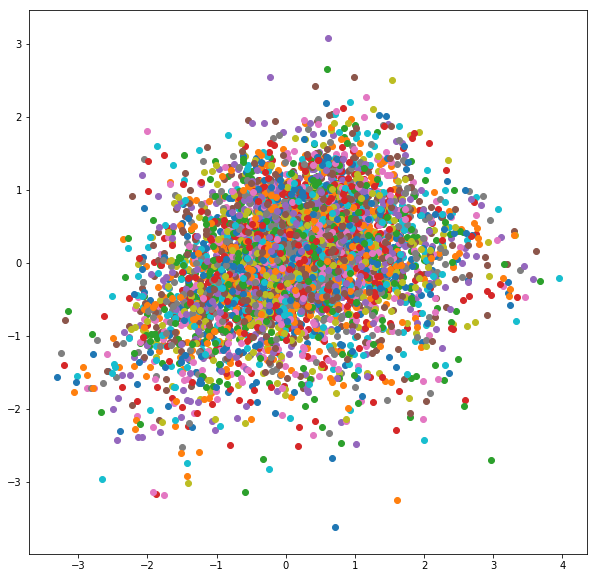

In [226]:
plt.figure(figsize=(10,10))
total_predictions = []
for i in range(len(height_arr)//image_data_generator.batch_size):
        images = image_data_generator.next()
        predictions = getParams(baseline, images, batch=True)
        total_predictions.append(predictions)
        plt.scatter(predictions[:,0], predictions[:,1])
        
    

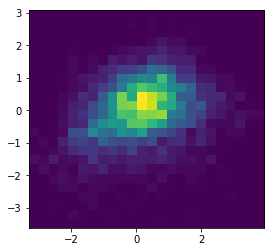

In [282]:
heatmap, xedges, yedges = np.histogram2d(predictions[:,0], predictions[:,1], bins=24)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')

The majority of the faces have been mapped to a distribution close to zero mean and zero log variance

In [54]:
def averageImage(img1, img2, decoder=decoder, encoder=baseline):
    return decoder.predict( (getParams(encoder, img1)+getParams(encoder,img2))/2, batch_size=1).reshape(img1.shape[0:2]) 

### Bigger Images

We want a way to find out how many images we can keep at a given size and what is the ideal dimensions to minimize lost images.

In [217]:
def weightedMedian(n, sigma=0.1):
    return int(np.median(np.c_[n]) * (1+sigma))
def percentageUnder(n, val, sigma=0.1):
    return (len([x for x in n if x*(1+sigma) < val]))/len(n)
def numberOfImages(n, val, sigma=0.1):
    return int(percentageUnder(n,val,sigma) * len(n))

len(height_arr) - numberOfImages(height_arr, 150)

3928

The training set will be slashed to 3133 images if it is constrained to just using images that are 
greater than or within 10% of 200x200 pixels.

In [233]:
removeSmallImages(size=(150,150), tmp_dir="/home/sam/Desktop/small_images/", sigma=0.15)

In [18]:


datagen_big = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)
image_data_generator_big = datagen_big.flow_from_directory("/home/sam/Desktop/temp/",
        target_size=(150,150), batch_size=1,
        class_mode=None, color_mode="grayscale")
test_data_generator_big = datagen_big.flow_from_directory("/home/sam/Desktop/test/",
        target_size=(150,150), 
        class_mode=None, color_mode="grayscale")

Found 4550 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


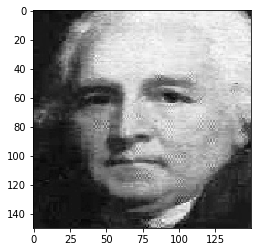

In [240]:
plt.imshow(image_data_generator_big.next()[0].reshape(150,150), cmap="Greys_r")

In [265]:
x = None

In [8]:
m = 50
n_z = 2 # latent dimension
n_epoch = 10
img_shape = (150,150,1)

# Q(z|X) -- encoder
inputs = Input(shape=img_shape)
"""
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)
"""
x = Conv2D(32,3, padding="same", activation="relu")(inputs)
x = Conv2D(64,3, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64,3, padding="same", activation="relu")(x)
x = Conv2D(64,3, padding="same", activation="relu")(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation="relu")(x)
mu = Dense(n_z, activation="linear")(x) # mean of the distribution
log_sigma = Dense(n_z, activation="linear")(x) 

# P(X|z) -- decoder

"""
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)
"""
z = Lambda(sample_z)([mu, log_sigma])
d_in = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation="relu") (d_in)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(150, 2, padding="same", activation="relu", strides=(2,2))(x)

x = Conv2D(1,2, padding="same", activation="sigmoid")(x)
decoder = Model(d_in, x)



z_decoded = decoder(z)
y = CustomVariationalLayer()([inputs, z_decoded])




In [40]:
vae = Model(inputs, y)
vae.compile(optimizer="rmsprop", loss=None)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 360000)            1080000   
_________________________________________________________________
reshape_13 (Reshape)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 150, 150, 150)     38550     
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 150, 150, 1)       601       
Total params: 1,119,151
Trainable params: 1,119,151
Non-trainable params: 0
_________________________________________________________________


In [41]:
callbacks = [

    ModelCheckpoint(
        filepath="/home/sam/Desktop/Classical/models/weights2.{epoch:02d}.hdf5"
    )
    
]

In [26]:
from keras.utils import plot_model

In [27]:
plot_model(vae, show_shapes=True, show_layer_names=True)

In [ ]:
history2 = vae.fit_generator(fixed_generator(image_data_generator_big),
        samples_per_epoch=4550,
        epochs=10,
        callbacks=callbacks)

In [9]:
bigger = keras.models.load_model("models/weights2.04.hdf5", 
                        custom_objects={"CustomVariationalLayer":CustomVariationalLayer()}, compile=False)

In [10]:
bigger.compile("rmsprop", loss=None)

In [12]:
big_decoder = bigger.get_layer("model_27")

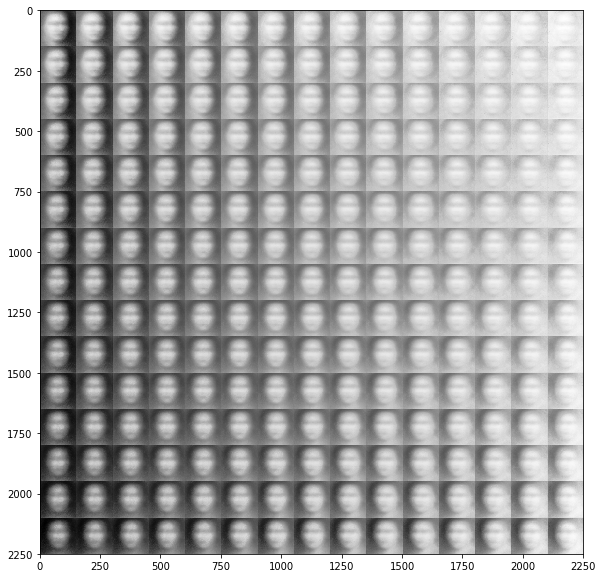

In [17]:
displayImages(big_decoder, dim=(150,150), directory="/home/sam/Desktop/Classical/figs/", name="150x150", batch_size=1)

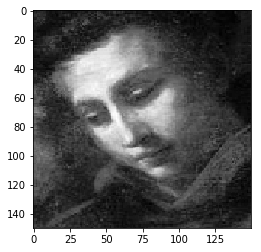

In [40]:
test = image_data_generator_big.next()[0]
plt.imshow(test.reshape(150,150), cmap="Greys_r")

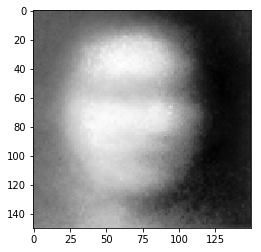

In [41]:
plt.imshow(big_decoder.predict(getParams(bigger,test, output_layer="lambda_14"), batch_size=1).reshape(150,150), cmap="Greys_r")

Pretty Terrible Model To be Honest

We need to go DEEPER and get more DATA.

### Medium Sized and Deeper

We will now attempt to train a medium sized model 100x100 with proper regularization and more data

In [4]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(K.shape(mu)[0], n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma) * eps

In [5]:
m = 50
n_z = 10 # latent dimension
n_epoch = 15
img_shape = (100,100,1)

# Q(z|X) -- encoder
inputs = Input(shape=img_shape)
"""
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)
"""
x = BatchNormalization()(inputs)
x = Conv2D(32,4, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64,2, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64,2, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(64,2, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2D(128,2, padding="same", activation="relu")(x)
x = Conv2D(128,2, padding="same", activation="relu")(x)
x = Conv2D(256,1, padding="same", activation="relu")(x)
x = Conv2D(256,1, padding="same", activation="relu")(x)

shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation="relu")(x)
mu = Dense(n_z, activation="linear")(x) # mean of the distribution
log_sigma = Dense(n_z, activation="linear")(x) 
z = Lambda(sample_z)([mu, log_sigma])
# P(X|z) -- decoder

d_in = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation="relu") (d_in)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(256,1, padding="same", activation="relu")(x)
x = Conv2DTranspose(256,1, padding="same", activation="relu")(x)
x = Conv2DTranspose(128, 2, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(64, 2, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2DTranspose(64, 2, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2DTranspose(64, 2, padding="same", activation="relu", strides=(2,2))(x)
x = Conv2DTranspose(1, 45, activation="relu", strides=(1,1))(x)


decoder = Model(d_in, x)



z_decoded = decoder(z)
y = CustomVariationalLayer()([inputs, z_decoded])




Instructions for updating:
Colocations handled automatically by placer.


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [17]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6272)              68992     
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 7, 7, 128)         65664     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 7, 7, 128)         65664     
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 28, 28, 64)        16448     
__________

In [7]:
normal= Model(inputs, y)
normal.compile("rmsprop", loss=None)
normal.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100, 100, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 32)   544         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 25, 64)   8256        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [10]:
callbacks = [

    ModelCheckpoint(
        filepath="/home/sam/Desktop/Classical/models/weight_normal.{epoch:02d}.hdf5"
    ),
    EarlyStopping(monitor="loss")
]

In [108]:
removeSmallImages(size=(100,100), sigma=0.1, tmp_dir = "/home/sam/Desktop/small_images/")

In [7]:
datagen_big = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)
image_data_generator_big = datagen_big.flow_from_directory(r"C:\Users\home\Downloads\faces",
        target_size=(100,100), batch_size=1,
        class_mode=None, color_mode="grayscale")
test_data_generator_big = datagen_big.flow_from_directory(r"C:\Users\home\Downloads\test",
        target_size=(100,100), 
        class_mode=None, color_mode="grayscale")

Found 6357 images belonging to 1 classes.
Found 303 images belonging to 1 classes.


In [ ]:
normal.fit_generator(fixed_generator(image_data_generator_big),steps_per_epoch=6414, epochs=10, callbacks=callbacks, validation_data=fixed_generator(test_data_generator_big), validation_steps=303)

In [26]:
normal = keras.models.load_model("./models/model_normal_06", 
                        custom_objects={"CustomVariationalLayer":CustomVariationalLayer()}, compile=False)

Instructions for updating:
Colocations handled automatically by placer.


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

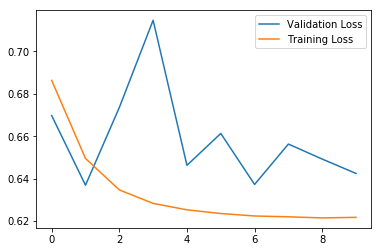

In [25]:
history = np.load("./History/history_normal.npy").tolist()
plt.plot(history["val_loss"], label="Validation Loss")
plt.plot(history["loss"], label="Training Loss")
plt.legend(loc="upper right")

In [8]:
q = next(image_data_generator_big)[0]

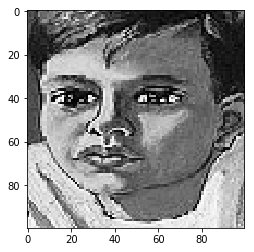

In [9]:
plt.imshow(q.reshape(100,100), cmap="Greys_r")

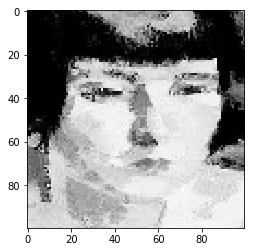

In [25]:
plt.imshow(normal.predict(q.reshape(1,100,100,1)).reshape(100,100), cmap="Greys_r")